In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

# 노트북 안에 그래프 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 gglot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# 데이터 로드
weight_df = pd.read_csv("data/tbl_file_collect(makgok).csv")
weight_df.shape

(11304, 9)

In [3]:
# weight
weight_df = weight_df[['CREATE_TIME', 'HOUSE_ID', 'MODULE_ID', 'FILE_INFO']]
weight_df['CREATE_TIME'] = pd.to_datetime(weight_df.CREATE_TIME, format='%Y-%m-%d %H:%M:%S')
weight_df['HOUSE_ID'] = weight_df['HOUSE_ID'].astype(str)
weight_df['MODULE_ID'] = weight_df['MODULE_ID'].astype(str)

In [4]:
def str_change_remove(x):
    data = x.split(',')
    data = [float(x) for x in data if x != '']
    data = data[1:]
    return data

weight_df['SENSOR_DATA'] = weight_df['FILE_INFO'].apply(str_change_remove)

In [5]:
weight_df['seqAsX'] = weight_df.reset_index().groupby('CREATE_TIME')['index'].transform(lambda x: x.rank(method='first')) / 30
weight_df['maxWeight'] = weight_df.groupby(['CREATE_TIME', 'HOUSE_ID', 'MODULE_ID'])[['SENSOR_DATA']].transform('max')

In [6]:
def apply_fn1(x, isPlot=False):
    df = pd.DataFrame(x)
    df_weight = pd.DataFrame(df['SENSOR_DATA'].iloc[0])
    df_weight.rename(columns={0:'SENSOR_DATA'}, inplace=True)

    # DBSCAN
    # if len(x) <= 1 : return pd.DataFrame({'sensor_data' : [0], 'seqAsX' : [0], 'gp_mean' : max(df['gp_mean'] )})
    model = DBSCAN(eps=15., min_samples=5, n_jobs=-1)  # min_samples=5,
    # df['predict'] = model.fit_predict(df[['SENSOR_DATA', 'seqAsX']])
    df_weight['predict'] = model.fit_predict(pd.DataFrame(df_weight['SENSOR_DATA']))

    dicts = df_weight[df_weight.predict != -1].groupby(['predict'])['SENSOR_DATA'].mean().to_dict()
    dicts2 = df_weight[df_weight.predict != -1].groupby(['predict'])['SENSOR_DATA'].count().to_dict()

    if isPlot:
        condition = (df_weight["predict"] == -1)
        plt.figure(figsize=(20, 10))
        plt.title(f' Raw Weight Outlier ')
        plt.scatter(x=df_weight[condition].index, y=df_weight[condition]['SENSOR_DATA'], color='red',label='outlier')
        plt.scatter(x=df_weight[~(condition)].index, y=df_weight[~(condition)]['SENSOR_DATA'], color='blue',label='normal')
        plt.legend(loc='best', ncol=3)
        plt.show()

    return pd.DataFrame({'house_id' : df['HOUSE_ID'].iloc[0],'module_id' : df['MODULE_ID'].iloc[0], 'create_time' : df['CREATE_TIME'].iloc[0], 'sensor_data': [x for x in dicts.values()], 'seqAsX': [x for x in dicts2.values()]})

In [7]:
weight_gp = weight_df.groupby(['HOUSE_ID', 'MODULE_ID', 'CREATE_TIME'])[['HOUSE_ID', 'MODULE_ID','CREATE_TIME','SENSOR_DATA', 'seqAsX']].apply(apply_fn1)

-------------------------------H01 -------------------------------
           create_time  sensor_data  seqAsX house_id module_id
0  2022-04-15 00:00:00   306.900000    15.0      H01   WE02081
1  2022-04-15 06:00:00   131.598333    16.5      H01   WE02081
2  2022-04-15 12:00:00   277.375571    16.0      H01   WE02081
3  2022-04-15 18:00:00   389.958810    20.0      H01   WE02081
4  2022-04-16 00:00:00   400.120667    14.0      H01   WE02081
5  2022-04-16 06:00:00   658.056522    16.0      H01   WE02081
6  2022-04-16 12:00:00   794.296667    16.0      H01   WE02081
7  2022-04-16 18:00:00   658.366667    20.0      H01   WE02081
8  2022-04-17 00:00:00   919.398462    16.0      H01   WE02081
9  2022-04-17 06:00:00   780.705714    17.5      H01   WE02081
10 2022-04-17 12:00:00  1041.890000    18.0      H01   WE02081
11 2022-04-17 18:00:00   778.574583    23.0      H01   WE02081
12 2022-04-18 00:00:00   656.030208    18.0      H01   WE02081
13 2022-04-18 06:00:00   614.370833    17.0      H0

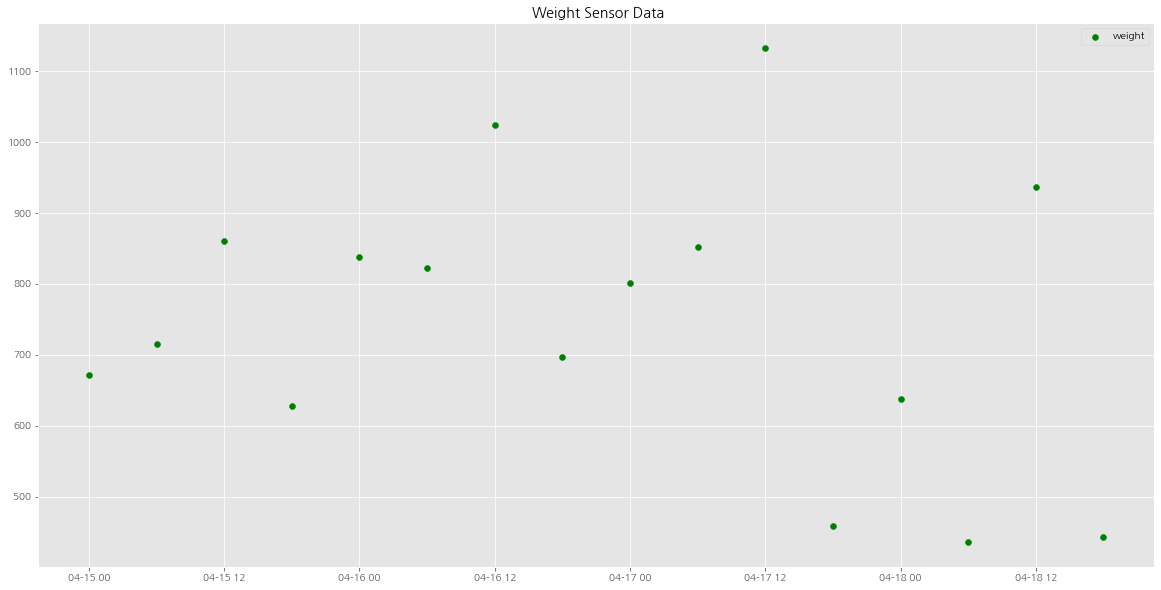

In [9]:
house_id_list = sorted(set(weight_gp['house_id']))
module_id_list = sorted(set(weight_gp['module_id']))

weight_df_total = pd.DataFrame()
for house_idx in house_id_list:
    print(f"-------------------------------{house_idx} -------------------------------")
    weight_house = weight_gp[weight_gp['house_id'] == house_idx]

    for module_idx in module_id_list :
        weight_df = weight_house[weight_house['module_id'] == module_idx].groupby(pd.Grouper(key='create_time', freq='6h')).median()
        if len(weight_df) == 0 :
            continue
        weight_df = weight_df.reset_index()
        weight_df['house_id'] = house_idx
        weight_df['module_id'] = module_idx

        print(weight_df)
        weight_df_total = pd.concat((weight_df_total, weight_df), sort=False)

isPlot = True
if isPlot:
    plt.figure(figsize=(20, 10))
    plt.title(f' Weight Sensor Data')
    #plt.scatter(x=weight_df_total[weight_df_total['house_id'] == 'H01']['create_time'], y=weight_df_total[weight_df_total['house_id'] == 'H01']['sensor_data'], color='red', label='weight')
    plt.scatter(x=weight_df_total[weight_df_total['house_id'] == 'H02']['create_time'], y=weight_df_total[weight_df_total['house_id'] == 'H02']['sensor_data'], color='green', label='weight')
    #plt.scatter(x=weight_df_total[weight_df_total['house_id'] == 'H03']['create_time'], y=weight_df_total[weight_df_total['house_id'] == 'H03']['sensor_data'], color='blue', label='weight')
    #plt.scatter(x=weight_df_total[weight_df_total['house_id'] == 'H04']['create_time'], y=weight_df_total[weight_df_total['house_id'] == 'H04']['sensor_data'], color='orange', label='weight')
    plt.legend(loc='best', ncol=4)
    plt.show()